<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/PVT/eclipseFluidCharNeqSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Python packages read Eclipse file and import Python libraries

In [1]:
%%capture
!pip install neqsim
!pip install wget
!wget https://raw.githubusercontent.com/EvenSol/NeqSim-Colab/master/notebooks/PVT/examplefile.txt

import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

#Read fluid from Eclipse 300 file

In [2]:
file1 = open('examplefile.txt', "r")
FileContent = file1.read()
print(FileContent)

-- Generated with ...
-- Fluid: TEST       
-- Database: test
-- Units
METRIC
-- Number of components:
NCOMPS
 7 /
-- Equation of state
EOS
SRK /
-- Reservoir temperature (C)
RTEMP
     30.00 /
-- Standard Conditions (C and bara)
STCOND
   15.00000    1.01325  /
-- Component names
CNAMES
N2+C1
CO2+C2+C
iC4-C6
C7-C10
C11-C20
C21-C35
C36-C80 /
-- Tc (K)
TCRIT
   190.491
   326.113
   456.737
   536.885
   638.575
   780.675
   933.953 /
-- Pc (Bar)
PCRIT
   45.9811
   52.4076
   34.3310
   26.6653
   24.3755
   21.3919
   22.1465 /
-- Omega
ACF
   0.00805
   0.14438
   0.23198
   0.51020
   0.70682
   1.03701
   1.32441 /
-- OmegaA
OMEGAA
     0.42748
     0.42748
     0.42748
     0.42748
     0.42748
     0.42748
     0.42748 /
-- OmegaB
OMEGAB
     0.08664
     0.08664
     0.08664
     0.08664
     0.08664
     0.08664
     0.08664 /
-- Molecular weights
MW
   16.0545
   36.4677
   68.0160
  109.1187
  177.1353
  322.5892
  527.7741 /
-- Boiling points (K)
TBOIL
   111.542
   202.030

#Create NeqSim fluid from Eclipse file
Run TP flash at reservoir temperature and pressure

In [3]:
fluid1 = readEclipseFluid('examplefile.txt')

reservoirPressure = 907
fluid1.setPressure(reservoirPressure, 'bara')
reservoirTemperature = 100.0 # C
fluid1.setTemperature(reservoirTemperature, 'C')

TPflash(fluid1)

printFrame(fluid1)

| 0                  | 1          | 2           | 3   | 4   | 5   | 6               |
|:-------------------|:-----------|:------------|:----|:----|:----|:----------------|
|                    | total      | OIL         |     |     |     |                 |
| N2+C1              | 8.2442E-1  | 8.2442E-1   |     |     |     | [mole fraction] |
| CO2+C2+C           | 1.06839E-1 | 1.06839E-1  |     |     |     | [mole fraction] |
| iC4-C6             | 3.6416E-2  | 3.6416E-2   |     |     |     | [mole fraction] |
| C7-C10             | 2.435E-2   | 2.435E-2    |     |     |     | [mole fraction] |
| C11-C20            | 7.734E-3   | 7.734E-3    |     |     |     | [mole fraction] |
| C21-C35            | 2.4E-4     | 2.4E-4      |     |     |     | [mole fraction] |
| C36-C80            | 1E-6       | 1E-6        |     |     |     | [mole fraction] |
|                    |            |             |     |     |     |                 |
| Density            |            | 4.02974E2   |     

#Create well streams, fit GVF, mix and separate

In [4]:
from neqsim.process import  mixer, heater, stream, separator, GORfitter

In [5]:
# Creating Well 1
well1 = stream(fluid1.clone())
well1.getFluid().setMolarComposition([0.3824420, 0.106839, 0.036416, 0.024350, 0.007734, 0.000240, 0.000001])
well1.setTemperature(55.0, 'C')
well1.setPressure(125.0, 'bara')
well1.setFlowRate(2000000.0, 'kg/hr')
well1.run()

well1GORfitter = GORfitter(well1)
well1GORfitter.setGVF(0.3) #setting GVF at meeter condition
well1GORfitter.setReferenceConditions('actual')
well1GORfitter.run()

well1Fitted = well1GORfitter.getOutStream()


#Creating Well 2
well2 = stream(fluid1.clone())
well2.setFlowRate(30000.0, 'kg/hr')
well2.getFluid().setMolarComposition([0.524420, 0.206839, 0.136416, 0.124350, 0.07734, 0.1240, 0.0021])
well2.setTemperature(55.0, 'C')
well2.setPressure(115.0, 'bara')
well2.setFlowRate(1200000.0, 'kg/hr')
well2.run()

well2GORfitter = GORfitter(well2)
well2GORfitter.setGVF(0.2) #setting GOR at meeter condition
well2GORfitter.setReferenceConditions('actual')
well2GORfitter.run()

well2Fitted = well2GORfitter.getOutStream()


#Mixing stream
wellmixer = mixer('well mixer')
wellmixer.addStream(well1Fitted)
wellmixer.addStream(well2Fitted)
wellmixer.run()

#Setting pressure and temperature of inlet separator
wellTP = heater(wellmixer.getOutStream())
wellTP.setOutTemperature(45.0, 'C')
wellTP.setOutPressure(65.0, 'bara')
wellTP.run()

#creating a inlet separator
inletsep = separator(wellTP.getOutStream())
inletsep.run()



gasFlowRate = inletsep.getGasOutStream().getFlowRate('MSm3/hr')
gasAFlowRate = inletsep.getGasOutStream().getFlowRate('m3/hr')
oilFlowRate = inletsep.getLiquidOutStream().getFlowRate('m3/hr')

print('gas flow rate from separator ', gasFlowRate, ' MSm3/hr')
print('gas flow rate from separator ', gasAFlowRate, ' Am3/hr')
print('oil flow rate from separator ', oilFlowRate, ' m3/hr')

gas flow rate from separator  0.5343879771185415  MSm3/hr
gas flow rate from separator  7764.513538145074  Am3/hr
oil flow rate from separator  3907.1951798675204  m3/hr


#Running a CME simulation for the reservoir fluid

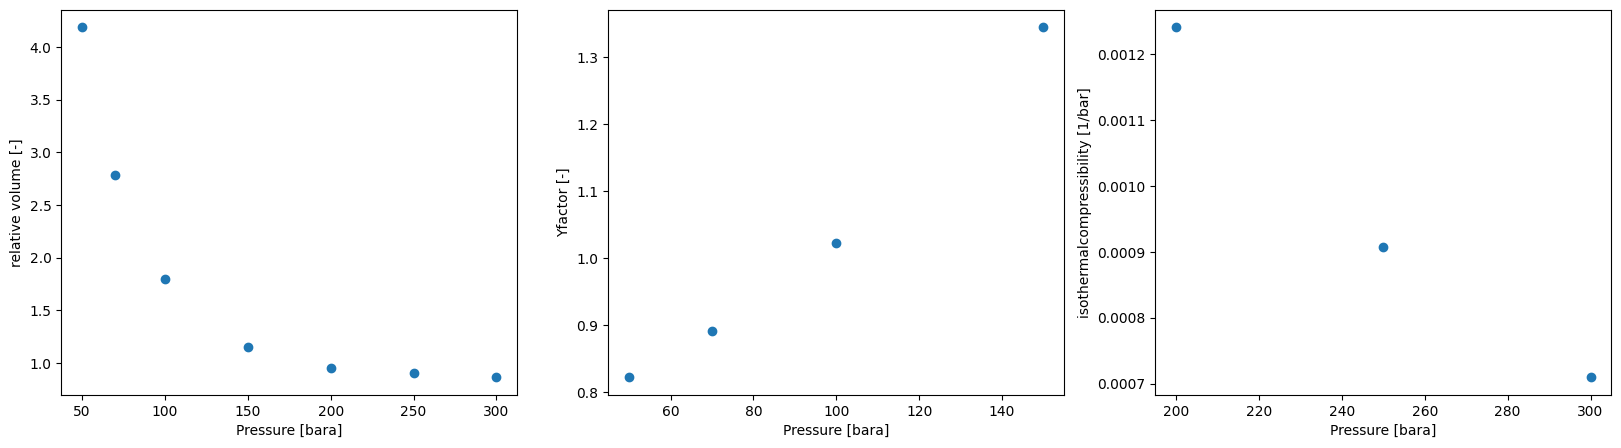

In [6]:
fluid1 = well1.getFluid().clone()

pressure = [300.0, 250.0, 200.0, 150.0, 100.0, 70.0, 50.0]
temperature = [301.0, 301.0, 301.0, 301.0, 301.0, 301.0, 301.0]

relativevolume = []
liquidrelativevolume = []
Zgas =  []
Yfactor = []
isothermalcompressibility = []
satPressure = None
CME(fluid1,pressure,temperature,satPressure,relativevolume, liquidrelativevolume,Zgas,Yfactor,isothermalcompressibility)

plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.plot(pressure, relativevolume, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('relative volume [-]')
plt.subplot(132)
plt.plot(pressure, Yfactor, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('Yfactor [-]')
plt.subplot(133)
plt.plot(pressure, isothermalcompressibility, "o")
plt.xlabel('Pressure [bara]')
plt.ylabel('isothermalcompressibility [1/bar]')
plt.show()